In [1]:
pip install pandas numpy matplotlib seaborn scikit-learn plotly dash


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 14.5 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: Flask
    Found existing installation: Flask 3.1.1
    Uninstalling Flask-3.1.1:
      Successfully uninstalled Flask-3.1.1


In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import  plotly.express as px
from math import sqrt
import numpy as np
import joblib

In [3]:

# Load the CSV file
filename = "/content/mobile_addiction.csv"
df = pd.read_csv(filename)

# Display basic info about the dataframe
df.info()

# Show the number of missing values per column
print("\nMissing values per column:")
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13589 entries, 0 to 13588
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          13589 non-null  int64 
 1   daily_screen_time   13589 non-null  int64 
 2   app_sessions        13589 non-null  int64 
 3   social_media_usage  13589 non-null  int64 
 4   gaming_time         13589 non-null  int64 
 5   notifications       13589 non-null  int64 
 6   night_usage         13589 non-null  int64 
 7   age                 13589 non-null  int64 
 8   work_study_hours    13589 non-null  int64 
 9   stress_level        13589 non-null  int64 
 10  apps_installed      13589 non-null  int64 
 11  addicted            13589 non-null  object
dtypes: int64(11), object(1)
memory usage: 1.2+ MB

Missing values per column:
Unnamed: 0            0
daily_screen_time     0
app_sessions          0
social_media_usage    0
gaming_time           0
notifications       

In [4]:
df = pd.read_csv("/content/mobile_addiction.csv")

# Step 1: Remove rows where daily screen time is less than sum of individual usage components
df_filtered = df[
    df["daily_screen_time"] >= (
        df["social_media_usage"] + df["gaming_time"] + df["night_usage"]
    )
]


# Step 3: Remove non-addicted people with more than 4 hours daily screen time
df_filtered = df_filtered[
    ~((df_filtered["addicted"] == "not addicted") &
      (df_filtered["social_media_usage"] + df_filtered["gaming_time"] + df_filtered["night_usage"] > 5)) &
    ~((df_filtered["addicted"] == "addicted") &
      (df_filtered["social_media_usage"] + df_filtered["gaming_time"] + df_filtered["night_usage"] < 4))
]


print(f"Rows removed: {len(df) - len(df_filtered)}")

# Optional: Save to a new CSV file
df_filtered.to_csv("cleaned_mobile_addiction.csv", index=False)

Rows removed: 6842


In [5]:
filename = "/content/cleaned_mobile_addiction.csv"
df = pd.read_csv(filename)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6747 entries, 0 to 6746
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          6747 non-null   int64 
 1   daily_screen_time   6747 non-null   int64 
 2   app_sessions        6747 non-null   int64 
 3   social_media_usage  6747 non-null   int64 
 4   gaming_time         6747 non-null   int64 
 5   notifications       6747 non-null   int64 
 6   night_usage         6747 non-null   int64 
 7   age                 6747 non-null   int64 
 8   work_study_hours    6747 non-null   int64 
 9   stress_level        6747 non-null   int64 
 10  apps_installed      6747 non-null   int64 
 11  addicted            6747 non-null   object
dtypes: int64(11), object(1)
memory usage: 632.7+ KB


In [6]:
df["addicted"] = df["addicted"].map({"addicted": 1, "not addicted": 0})

# Create a label column for plot display


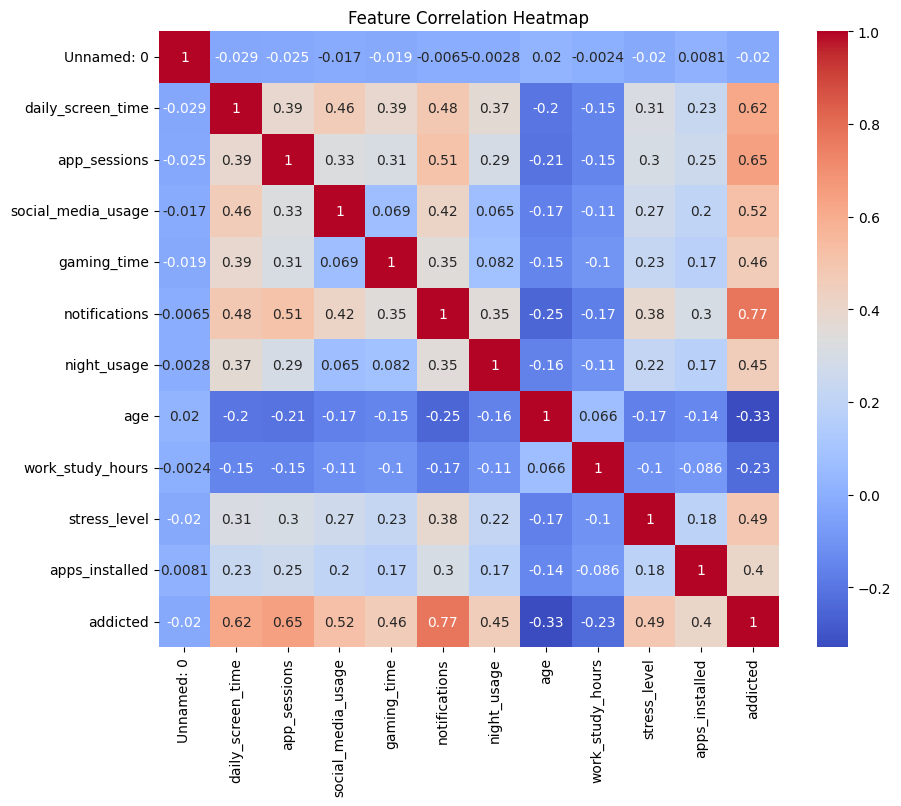

In [7]:


plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()
df1=df.copy()
df2=df.copy()



In [8]:

df["type"] = df["addicted"].map({1: "addicted", 0: "not addicted"})
fig = px.pie(df, names='type', title='Addicted vs Not Addicted Users')
fig.update_layout(width=500, height=500)
fig.show()

In [9]:
fig = px.histogram(df, x='daily_screen_time', color='type', title='Daily Screen Time Distribution')
fig.update_layout(width=700, height=700)

fig.show()


In [10]:
fig = px.scatter(df, x='daily_screen_time', y='stress_level', color='addicted', title='Screen Time vs Stress Level')
fig.show()


In [11]:
fig = px.box(df, x='type', y='night_usage', title='Night Usage by Addiction Status')
fig.show()


In [17]:


from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Load and clean data
df = pd.read_csv("/content/cleaned_mobile_addiction.csv")
df_clean = df.drop(columns=['Unnamed: 0','addicted'])

# Features and target
X = df_clean.drop(columns=['daily_screen_time'])
y = df_clean['daily_screen_time']

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Store MSEs, R2s and accuracies
mse_results = {}
r2_results = {}
accuracy_results = {}
# Initialize variables to track the best model
best_model = None
best_degree = None
best_r2 = -np.inf
best_scaler = scaler  # Keep track of the scaler used
best_poly = None

for degree in range(1, 5):
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly.fit_transform(X_scaled)

    X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred_test = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred_test)
    r2 = r2_score(y_test, y_pred_test)
    rmse = np.sqrt(mse)
    mean_actual = np.mean(y_test)
    accuracy = 1 - (rmse / mean_actual)

    mse_results[f'd{degree}'] = mse
    r2_results[f'd{degree}'] = r2
    accuracy_results[f'd{degree}'] = accuracy

    if r2 > best_r2:
        best_r2 = r2
        best_model = model
        best_degree = degree
        best_scaler = scaler
        best_poly = poly

# Save best model and preprocessors
joblib.dump(best_model, f'best_poly_model_degree_{best_degree}.pkl')
joblib.dump(best_scaler, 'scaler.pkl')
joblib.dump(best_poly, 'poly_transformer.pkl')


# Print MSEs, R2s and accuracies
for degree in range(1, 5):
    print(f"d{degree}: Test MSE = {mse_results[f'd{degree}']:.4f}, Test R2 = {r2_results[f'd{degree}']:.4f}, Approx Accuracy = {accuracy_results[f'd{degree}']:.4f}")
print(f"Saved best model with degree {best_degree} (R² = {best_r2:.4f})")


d1: Test MSE = 1.7144, Test R2 = 0.4381, Approx Accuracy = 0.7012
d2: Test MSE = 1.6784, Test R2 = 0.4499, Approx Accuracy = 0.7043
d3: Test MSE = 1.7204, Test R2 = 0.4361, Approx Accuracy = 0.7006
d4: Test MSE = 2.0062, Test R2 = 0.3424, Approx Accuracy = 0.6767
Saved best model with degree 2 (R² = 0.4499)


In [18]:
print("Feature order:")
print(list(X.columns))

Feature order:
['app_sessions', 'social_media_usage', 'gaming_time', 'notifications', 'night_usage', 'age', 'work_study_hours', 'stress_level', 'apps_installed']


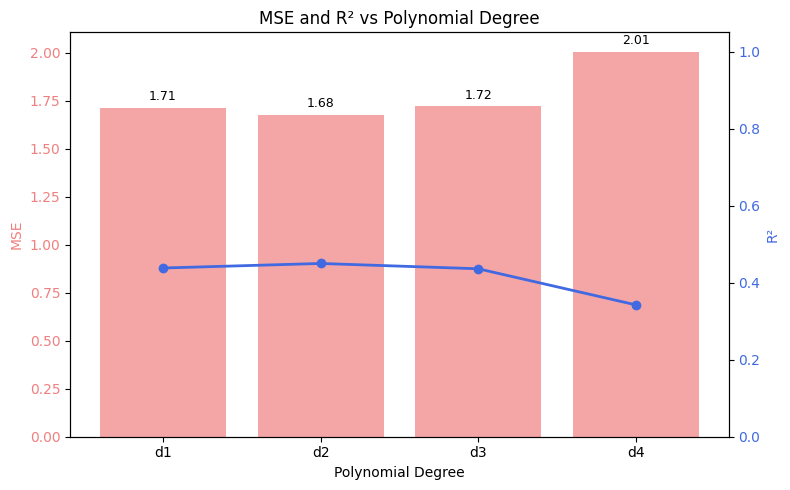

In [19]:

from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


# -------- Visualization --------
degrees = list(mse_results.keys())
mse_list = list(mse_results.values())
r2_list = list(r2_results.values())

# Create a figure
fig, ax1 = plt.subplots(figsize=(8, 5))

# Bar plot for MSE
bars = ax1.bar(degrees, mse_list, color='lightcoral', alpha=0.7, label='MSE')
ax1.set_xlabel('Polynomial Degree')
ax1.set_ylabel('MSE', color='lightcoral')
ax1.tick_params(axis='y', labelcolor='lightcoral')
ax1.set_title('MSE and R² vs Polynomial Degree')

# Line plot for R2
ax2 = ax1.twinx()
ax2.plot(degrees, r2_list, color='royalblue', marker='o', linewidth=2, label='R²')
ax2.set_ylabel('R²', color='royalblue')
ax2.tick_params(axis='y', labelcolor='royalblue')
ax2.set_ylim(0, 1.05)

# Show value labels for bars
for bar in bars:
    height = bar.get_height()
    ax1.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

# Add legend
fig.tight_layout()
plt.show()


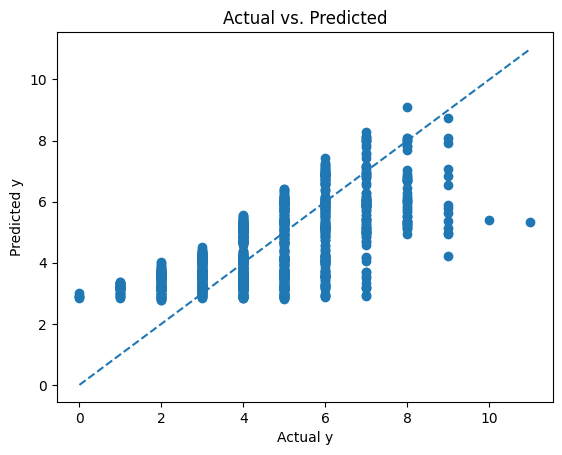

In [20]:

# Use the best performing polynomial degree (e.g., degree = 2)
best_degree = 2
poly = PolynomialFeatures(degree=best_degree, include_bias=False)
X_poly = poly.fit_transform(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# y_test and y_pred from your model.predict
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle='--')  # diagonal ↗ for perfect predictions

plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('Actual vs. Predicted')
plt.show()


     alpha  Train_MSE  Train_R2  Train_Accuracy  Test_MSE   Test_R2  \
0    0.001   1.657929  0.455013        0.700271  1.714353  0.438058   
1    0.010   1.657929  0.455013        0.700271  1.714353  0.438059   
2    0.100   1.657929  0.455013        0.700271  1.714352  0.438059   
3    1.000   1.657929  0.455013        0.700271  1.714336  0.438064   
4   10.000   1.657933  0.455011        0.700271  1.714186  0.438113   
5  100.000   1.658271  0.454900        0.700240  1.713021  0.438495   

   Test_Accuracy  
0       0.701167  
1       0.701167  
2       0.701167  
3       0.701168  
4       0.701181  
5       0.701283  


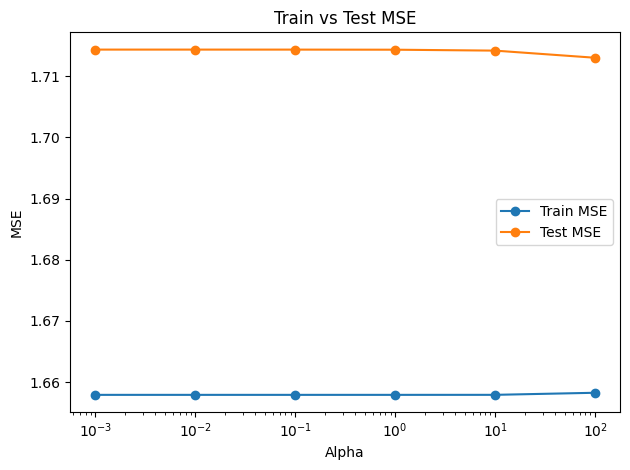

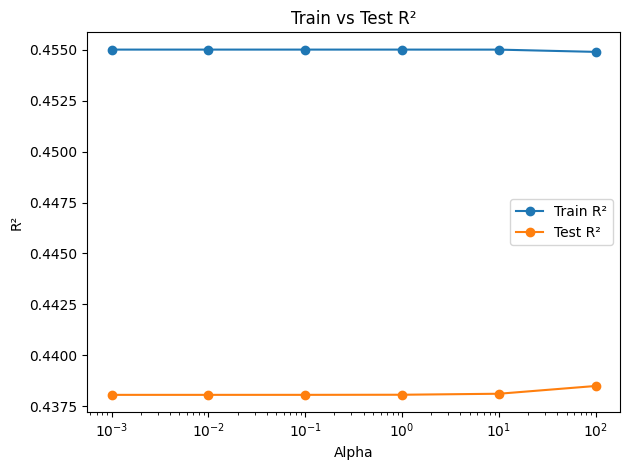

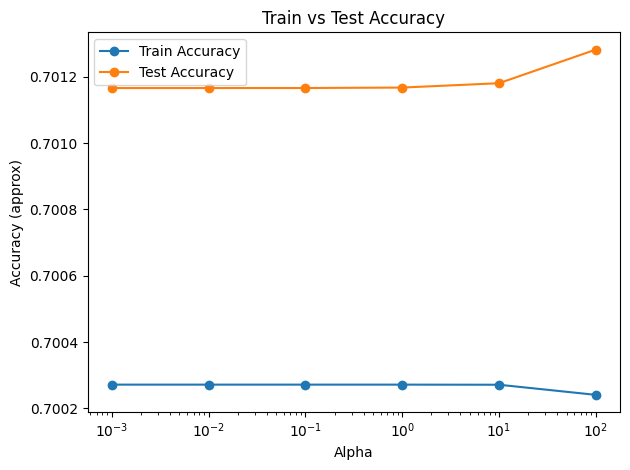

In [21]:

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from math import sqrt

# 1. Load and clean data
df = pd.read_csv("/content/cleaned_mobile_addiction.csv")  # adjust path if needed
df = df.drop(columns=['Unnamed: 0', 'addicted'])

# 2. Prepare features & target
X = df.drop(columns=['daily_screen_time'])
y = df['daily_screen_time']

# 3. Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# 5. Ridge alphas to try
alphas = [0.001, 0.01, 0.1, 1, 10, 100]

# 6. Containers for metrics
results = {
    'alpha': [],
    'Train_MSE': [], 'Train_R2': [], 'Train_Accuracy': [],
    'Test_MSE': [],  'Test_R2': [],  'Test_Accuracy': []
}

# 7. Loop over alphas
for alpha in alphas:
    model = Ridge(alpha=alpha)
    model.fit(X_train, y_train)

    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test  = model.predict(X_test)

    # Compute metrics
    train_mse = mean_squared_error(y_train, y_pred_train)
    train_r2  = r2_score(y_train, y_pred_train)
    train_rmse = sqrt(train_mse)
    train_accuracy = 1 - (train_rmse / np.mean(y_train))

    test_mse = mean_squared_error(y_test, y_pred_test)
    test_r2  = r2_score(y_test, y_pred_test)
    test_rmse = sqrt(test_mse)
    test_accuracy = 1 - (test_rmse / np.mean(y_test))

    # Store
    results['alpha'].append(alpha)
    results['Train_MSE'].append(train_mse)
    results['Train_R2'].append(train_r2)
    results['Train_Accuracy'].append(train_accuracy)
    results['Test_MSE'].append(test_mse)
    results['Test_R2'].append(test_r2)
    results['Test_Accuracy'].append(test_accuracy)

# 8. Convert to DataFrame & display
results_df = pd.DataFrame(results)
print(results_df)

# 9. Plot Train vs Test MSE
plt.figure()
plt.plot(results_df['alpha'], results_df['Train_MSE'], marker='o', label='Train MSE')
plt.plot(results_df['alpha'], results_df['Test_MSE'],  marker='o', label='Test MSE')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.title('Train vs Test MSE')
plt.legend()
plt.tight_layout()
plt.show()

# 10. Plot Train vs Test R²
plt.figure()
plt.plot(results_df['alpha'], results_df['Train_R2'], marker='o', label='Train R²')
plt.plot(results_df['alpha'], results_df['Test_R2'],  marker='o', label='Test R²')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('R²')
plt.title('Train vs Test R²')
plt.legend()
plt.tight_layout()
plt.show()

# 11. Plot Train vs Test Accuracy
plt.figure()
plt.plot(results_df['alpha'], results_df['Train_Accuracy'], marker='o', label='Train Accuracy')
plt.plot(results_df['alpha'], results_df['Test_Accuracy'],  marker='o', label='Test Accuracy')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Accuracy (approx)')
plt.title('Train vs Test Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


α=0.001: Test MSE = 1.7143, Test R² = 0.4381, Accuracy = 0.7012
α=0.01: Test MSE = 1.7145, Test R² = 0.4380, Accuracy = 0.7011
α=0.1: Test MSE = 1.7403, Test R² = 0.4295, Accuracy = 0.6989
α=1: Test MSE = 3.0581, Test R² = -0.0024, Accuracy = 0.6009
α=10: Test MSE = 3.0581, Test R² = -0.0024, Accuracy = 0.6009
α=100: Test MSE = 3.0581, Test R² = -0.0024, Accuracy = 0.6009


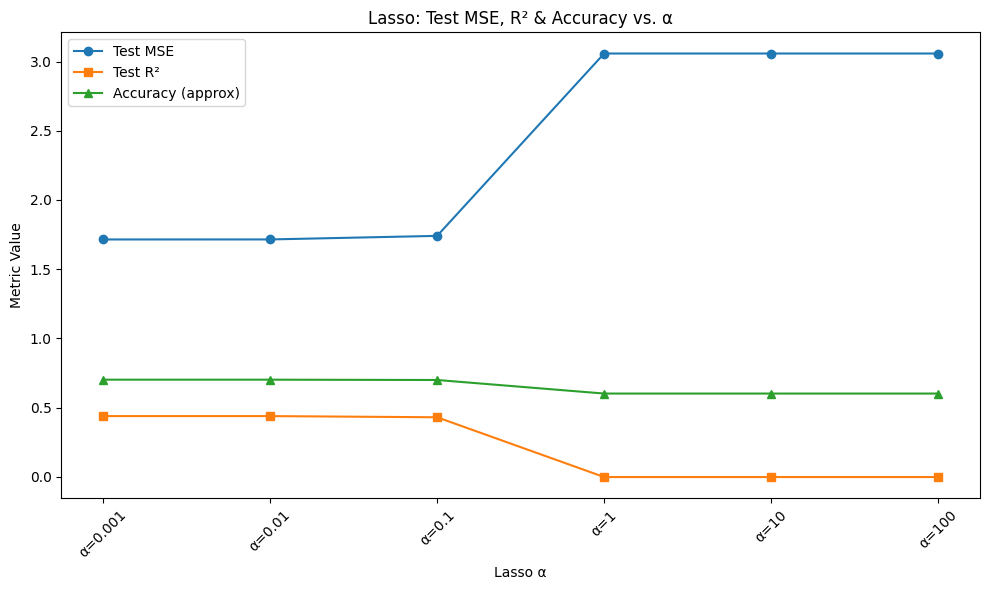

In [22]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

# Assume df_clean, X, y are already defined as in your Ridge section
# 1. Load and clean data
df = pd.read_csv("/content/cleaned_mobile_addiction.csv")  # adjust path if needed
df = df.drop(columns=['Unnamed: 0', 'addicted'])

# 2. Prepare features & target
X = df.drop(columns=['daily_screen_time'])
y = df['daily_screen_time']

# 3. Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)
# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# α values to try
alphas = [0.001, 0.01, 0.1, 1, 10, 100]

mse_results = {}
r2_results = {}
accuracy_results = {}

for alpha in alphas:
    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42
    )
    # fit Lasso
    model = Lasso(alpha=alpha, max_iter=10000)
    model.fit(X_train, y_train)
    # predict & evaluate
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2  = r2_score(y_test, y_pred)
    rmse = sqrt(mse)
    mean_actual = np.mean(y_test)
    accuracy = 1 - (rmse / mean_actual)

    mse_results[f'α={alpha}'] = mse
    r2_results[f'α={alpha}'] = r2
    accuracy_results[f'α={alpha}'] = accuracy

# Print summary
for alpha in alphas:
    key = f'α={alpha}'
    print(f"{key}: Test MSE = {mse_results[key]:.4f}, Test R² = {r2_results[key]:.4f}, Accuracy = {accuracy_results[key]:.4f}")

# Plot MSE, R² and Accuracy vs. α
plt.figure(figsize=(10, 6))
plt.plot(list(mse_results.keys()), list(mse_results.values()),
         marker='o', label='Test MSE')
plt.plot(list(r2_results.keys()), list(r2_results.values()),
         marker='s', label='Test R²')
plt.plot(list(accuracy_results.keys()), list(accuracy_results.values()),
         marker='^', label='Accuracy (approx)')
plt.xlabel('Lasso α')
plt.ylabel('Metric Value')
plt.title('Lasso: Test MSE, R² & Accuracy vs. α')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


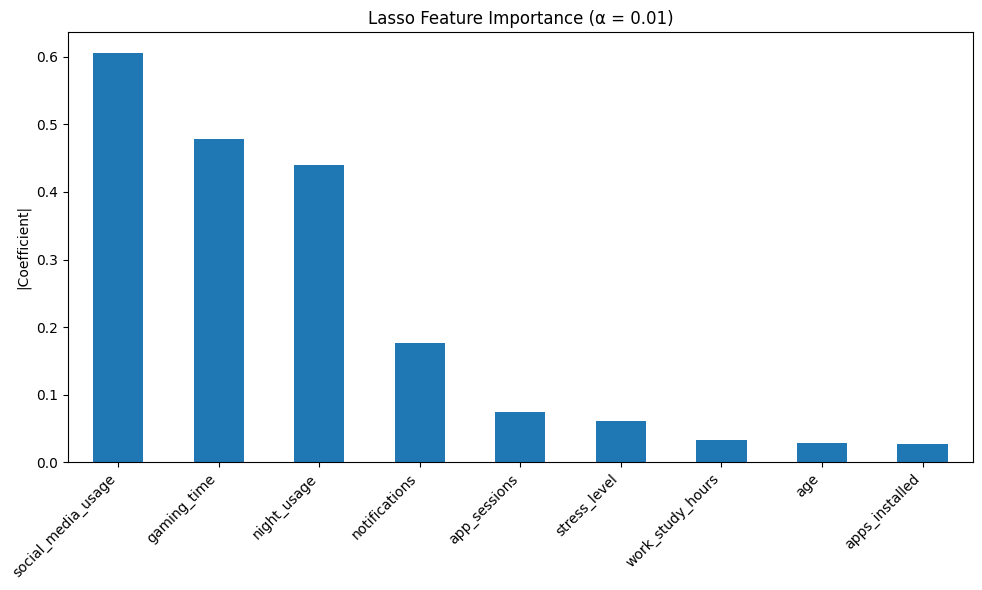

In [23]:

from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# --- 1. Reload & prepare your data ---
df = pd.read_csv("/content/cleaned_mobile_addiction.csv")
df = df.drop(columns=['Unnamed: 0','addicted'])

X = df.drop(columns=['daily_screen_time'])
y = df['daily_screen_time']

# --- 2. Standardize ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 3. Pick the alpha with lowest MSE from your earlier results ---
#    (e.g. you found that alpha=0.01 gave the best test MSE)
best_alpha = 0.01

# --- 4. Refit Lasso on the whole dataset (or just train split) ---
model = Lasso(alpha=best_alpha, max_iter=10_000)
model.fit(X_scaled, y)

# --- 5. Extract coefficients and sort by absolute magnitude ---
coefs = pd.Series(model.coef_, index=X.columns)
coefs_abs = coefs.abs().sort_values(ascending=False)

# --- 6. Plot ---
plt.figure(figsize=(10, 6))
coefs_abs.plot(kind='bar')
plt.xticks(rotation=45, ha='right')
plt.ylabel('|Coefficient|')
plt.title(f'Lasso Feature Importance (α = {best_alpha})')
plt.tight_layout()
plt.show()

Test Accuracy: 0.9896
ROC AUC Score: 0.9996

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       395
           1       0.99      0.99      0.99       955

    accuracy                           0.99      1350
   macro avg       0.99      0.99      0.99      1350
weighted avg       0.99      0.99      0.99      1350



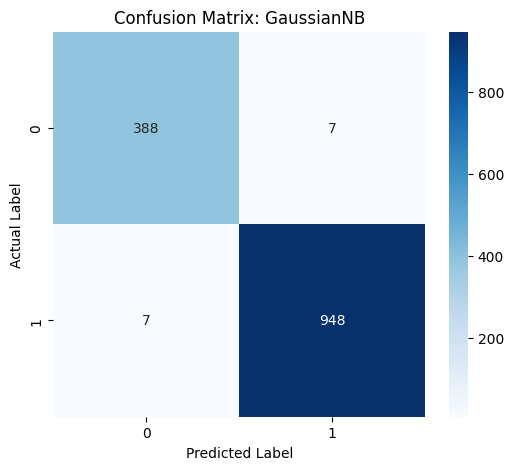

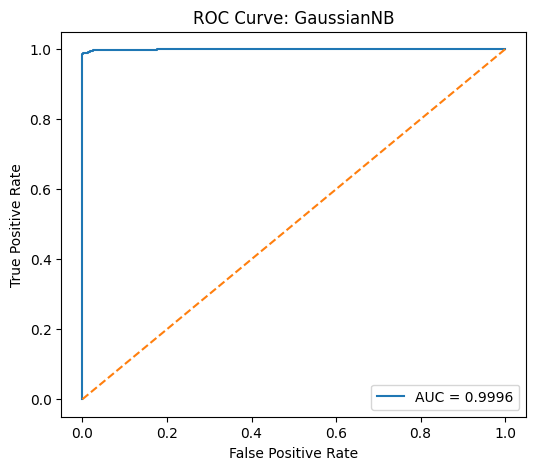


Models and transformer saved successfully.


In [24]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve


# -------------------------
# 1. Load & Clean Data
# -------------------------
df = pd.read_csv("/content/cleaned_mobile_addiction.csv")
df.drop(columns=['Unnamed: 0', 'daily_screen_time'], inplace=True)
df['addicted'] = LabelEncoder().fit_transform(df['addicted'])

# -------------------------
# 2. Features & Target
# -------------------------
feature_names = [
    'app_sessions', 'social_media_usage', 'gaming_time',
    'notifications', 'night_usage', 'age',
    'work_study_hours', 'stress_level', 'apps_installed'
]
X = df[feature_names]
y = df['addicted']

# -------------------------
# 3. Train/Test Split
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -------------------------
# 4. Scale Features
# -------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# -------------------------
# 5. Train Gaussian Naïve Bayes
# -------------------------
nb = GaussianNB()
nb.fit(X_train_scaled, y_train)

# -------------------------
# 6. Evaluate on Test Set
# -------------------------
y_pred  = nb.predict(X_test_scaled)
y_proba = nb.predict_proba(X_test_scaled)[:, 1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)
print(f"Test Accuracy: {acc:.4f}")
print(f"ROC AUC Score: {auc:.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix: GaussianNB')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0,1],[0,1], linestyle='--')
plt.title('ROC Curve: GaussianNB')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# -------------------------
# 7. Save Model & Scaler
# -------------------------
joblib.dump(scaler, 'scaler_nb.joblib')
joblib.dump(nb,     'gaussian_nb_model.joblib')
print("\nModels and transformer saved successfully.")

# -------------------------
# 8. Example Inference w/ 80% Threshold
# -------------------------
# (Very low-usage sample to illustrate “Not Addicted”)
example = pd.DataFrame(
    [[0, 0, 0, 0, 0, 30, 0, 0, 0]],
    columns=feature_names
)
ex_scaled = scaler.transform(example)
p_add = nb.predict_proba(ex_scaled)[0,1]
threshold = 0.80
label = "Addicted" if p_add >= threshold else "Not Addicted"



In [25]:
print("Feature order:")
print(list(X.columns))


Feature order:
['app_sessions', 'social_media_usage', 'gaming_time', 'notifications', 'night_usage', 'age', 'work_study_hours', 'stress_level', 'apps_installed']


Test Accuracy: 0.9941
ROC AUC Score: 0.9985

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       395
           1       0.99      1.00      1.00       955

    accuracy                           0.99      1350
   macro avg       0.99      0.99      0.99      1350
weighted avg       0.99      0.99      0.99      1350



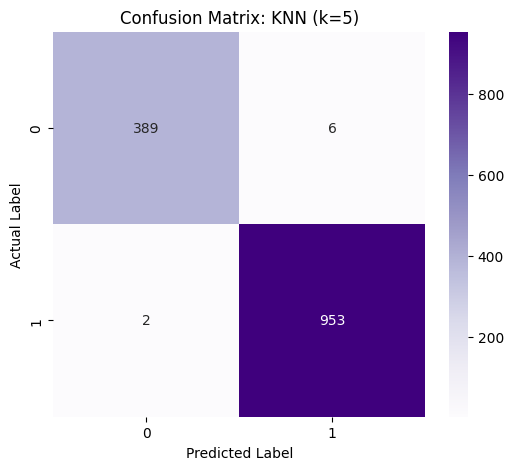

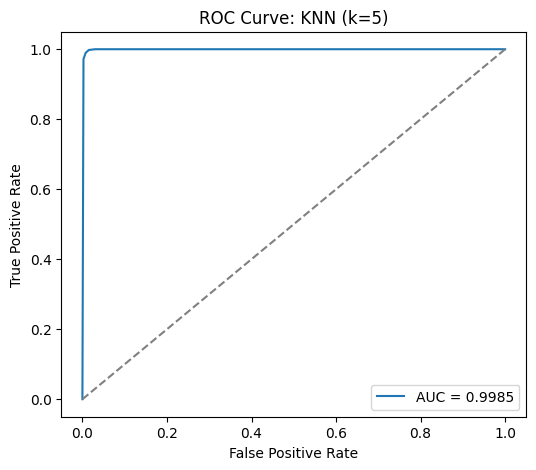

In [26]:
# --- Classification with K-Nearest Neighbors ---

from sklearn.preprocessing    import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.metrics         import (
    accuracy_score, classification_report,
    confusion_matrix, roc_auc_score, roc_curve
)

# 1) Load & clean
df = pd.read_csv("/content/cleaned_mobile_addiction.csv")
df = df.drop(columns=['Unnamed: 0', 'daily_screen_time'])
df['addicted'] = LabelEncoder().fit_transform(df['addicted'])

# 2) Features & target
X = df.drop(columns=['addicted'])
y = df['addicted']

# 3) Train/test split (stratify to preserve class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4) Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 5) Train KNN
knn = KNeighborsClassifier(n_neighbors=5)   # try other k’s here!
knn.fit(X_train_scaled, y_train)

# 6) Predictions & probabilities
y_pred  = knn.predict(X_test_scaled)
y_proba = knn.predict_proba(X_test_scaled)[:, 1]  # probability of class “1”

# 7) Evaluation metrics
acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)
print(f"Test Accuracy: {acc:.4f}")
print(f"ROC AUC Score: {auc:.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# 8) Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Purples')
plt.title('Confusion Matrix: KNN (k=5)')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

# 9) ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve: KNN (k=5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


5-fold CV accuracies: [0.99  0.985 0.988 0.99  0.978 0.994 0.982 0.99  0.996 0.985]
Mean CV accuracy   : 0.988 

Test Accuracy: 0.9867
ROC AUC Score: 0.9993

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       395
           1       0.99      0.99      0.99       955

    accuracy                           0.99      1350
   macro avg       0.98      0.98      0.98      1350
weighted avg       0.99      0.99      0.99      1350



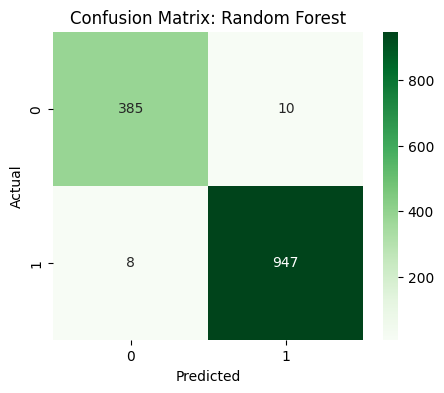

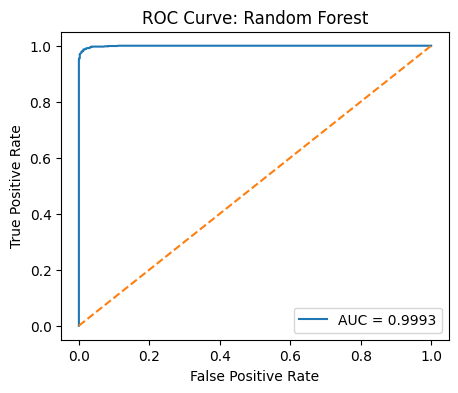

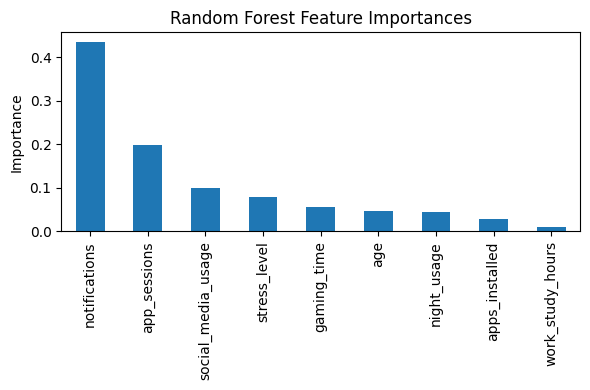

In [27]:
# --- Classification with Random Forest (handles feature dependencies) ---

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, roc_auc_score,
    classification_report, confusion_matrix, roc_curve
)

# 1) Load & clean
df = pd.read_csv("/content/cleaned_mobile_addiction.csv")
df = df.drop(columns=['Unnamed: 0', 'daily_screen_time'])
df['addicted'] = LabelEncoder().fit_transform(df['addicted'])

# 2) Features & target
X = df.drop(columns=['addicted'])
y = df['addicted']

# 3) 5-fold CV accuracy
rf = RandomForestClassifier(n_estimators=100, random_state=42)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf, X, y, cv=cv, scoring='accuracy')
print("5-fold CV accuracies:", cv_scores.round(3))
print("Mean CV accuracy   :", cv_scores.mean().round(3), "\n")

# 4) Train/test split & fit
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
rf.fit(X_train, y_train)

# 5) Held-out test evaluation
y_pred  = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# 6) Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix: Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 7) ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba):.4f}')
plt.plot([0,1],[0,1], linestyle='--')
plt.title('ROC Curve: Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# 8) Feature Importances
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot.bar(figsize=(6,4))
plt.title("Random Forest Feature Importances")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


In [31]:

from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    mean_squared_error, r2_score,
    accuracy_score, classification_report,
    confusion_matrix, roc_auc_score, roc_curve
)
import ipywidgets as widgets
from IPython.display import display
from sklearn.pipeline import make_pipeline

# --- Load & clean ---
df = pd.read_csv("/content/cleaned_mobile_addiction.csv")
df_clean = df.drop(columns=['Unnamed: 0', 'age'])
df_clean['addicted'] = LabelEncoder().fit_transform(df_clean['addicted'])

# --- Regression setup & train ---
Xr = df_clean.drop(columns=['daily_screen_time', 'addicted'])
yr = df_clean['daily_screen_time']

Xr_tr, Xr_te, yr_tr, yr_te = train_test_split(Xr, yr, test_size=0.2, random_state=42)
sc_r = StandardScaler().fit(Xr_tr)
Xr_tr_s, Xr_te_s = sc_r.transform(Xr_tr), sc_r.transform(Xr_te)

# Store test target for dashboard use
yr_te = yr_te  # <- This is used in dashboard plots

reg_models = {
    'Polynomial Linear (deg=2)': make_pipeline(PolynomialFeatures(degree=2), LinearRegression()),
    'Ridge (alpha=0.1)': Ridge(alpha=0.1),
    'Lasso (alpha=0.01)': Lasso(alpha=0.01)
}

reg_results = {}
for name, model in reg_models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    reg_results[name] = {
        'model': model,
        'MSE': mean_squared_error(y_test, preds),
        'R2': r2_score(y_test, preds),
        'pred': preds
        'acc': accuracy_score(y_test, preds)
    }
    # --- REGRESSION SETUP ---
X = df_clean.drop(columns=['daily_screen_time'])
y = df_clean['daily_screen_time']
X_scaled = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [32]:
# --- Classification setup & train ---
dfc = df_clean.drop(columns=['daily_screen_time'])
dfc['addicted_enc'] = LabelEncoder().fit_transform(dfc['addicted'])
Xc = dfc.drop(columns=['addicted','addicted_enc'])
yc = dfc['addicted_enc']
Xc_tr, Xc_te, yc_tr, yc_te = train_test_split(Xc,yc,test_size=0.2,stratify=yc,random_state=42)
sc_c = StandardScaler().fit(Xc_tr)
Xc_tr_s, Xc_te_s = sc_c.transform(Xc_tr), sc_c.transform(Xc_te)

clf_models = {
    'NB':        GaussianNB(),
    'KNN (k=5)':      KNeighborsClassifier(n_neighbors=5),

    'RF':        RandomForestClassifier(n_estimators=100,random_state=42)
}
clf_results = {}
for n,m in clf_models.items():
    m.fit(Xc_tr_s,yc_tr)
    yp = m.predict(Xc_te_s)
    prob = m.predict_proba(Xc_te_s)[:,1] if hasattr(m,'predict_proba') else None
    clf_results[n] = {
        'accuracy': accuracy_score(yc_te,yp),
        'auc':      roc_auc_score(yc_te,prob) if prob is not None else None,
        'conf_mat': confusion_matrix(yc_te,yp),
        'roc':      roc_curve(yc_te,prob) if prob is not None else None
    }


In [33]:
# --- IMPORTS ---

from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
import ipywidgets as widgets
from IPython.display import display, clear_output
from sklearn.pipeline import make_pipeline

# Required for plotting in notebooks
%matplotlib inline

# --- LOAD & CLEAN DATA ---
df = pd.read_csv("/content/cleaned_mobile_addiction.csv")
df_clean['addicted'] = LabelEncoder().fit_transform(df_clean['addicted'])




# --- DASHBOARD OUTPUTS ---
eda_out = widgets.Output()
reg_out = widgets.Output()
clf_out = widgets.Output()

# --- EDA TAB ---

with eda_out:
    # Convert 'addicted' back to readable labels for better plots
    df_clean['addicted_label'] = df_clean['addicted'].map({1: 'Addicted', 0: 'Not Addicted'})

    # Histogram (Univariate Analysis)
    plt.figure(figsize=(8, 6))
    sns.histplot(df_clean['daily_screen_time'], kde=True)
    plt.title("Distribution of Daily Screen Time")
    plt.xlabel("Daily Screen Time (hours)")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

    # Heatmap (Multivariate Analysis)
    plt.figure(figsize=(10, 8))
    sns.heatmap(df1.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Correlation Heatmap")
    plt.tight_layout()
    plt.show()

    # Boxplot (Bivariate Analysis)
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='addicted_label', y='night_usage', data=df_clean)
    plt.title("Screen Time by Addiction Status")
    plt.xlabel("Addiction Status")
    plt.ylabel("Daily Screen Time")
    plt.tight_layout()
    plt.show()

    # Scatter Plot (Bivariate Analysis)
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='daily_screen_time', y='stress_level', hue='addicted_label', data=df_clean)
    plt.title("Gaming Time vs Social Media Usage")
    plt.xlabel("Gaming Time (hours)")
    plt.ylabel("Social Media Usage (hours)")
    plt.tight_layout()
    plt.show()

    # Pie Chart (Distribution & Composition)
    plt.figure(figsize=(8, 6))
    addiction_counts = df_clean['addicted_label'].value_counts()
    plt.pie(addiction_counts, labels=addiction_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title("Addiction Status Distribution")
    plt.axis('equal')  # Makes the pie chart a circle
    plt.tight_layout()
    plt.show()


# --- REGRESSION TAB ---
with reg_out:
    model_dropdown = widgets.Dropdown(options=list(reg_results.keys()), description='Model:')
    out = widgets.Output()
    display(model_dropdown, out)

    def show_regression(change):
        with out:
            clear_output(wait=True)
            name = change['new']
            res = reg_results[name]

            print(f"{name}:")
            print(f"  MSE = {res['MSE']:.4f}")
            print(f"  R²  = {res['R2']:.4f}")

            plt.figure(figsize=(8, 6))
            plt.scatter(y_test, res['pred'], alpha=0.7)
            plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
            plt.xlabel("Actual")
            plt.ylabel("Predicted")
            plt.title(f"{name} - Actual vs Predicted")
            plt.tight_layout()
            plt.show()

    model_dropdown.observe(show_regression, names='value')
    model_dropdown.value = model_dropdown.options[0]

# --- CLASSIFICATION TAB ---
with clf_out:
    dd = widgets.Dropdown(options=list(clf_results.keys()), description='Model:')
    clf_box = widgets.Output()
    display(dd, clf_box)

    def show_classification(chg):
        with clf_box:
            clear_output(wait=True)
            res = clf_results[chg['new']]
            print("Accuracy:", res['accuracy'], "AUC:", res['auc'])
            sns.heatmap(res['conf_mat'], annot=True, fmt='d')
            plt.title("Confusion Matrix")
            plt.show()

    dd.observe(show_classification, names='value')
    dd.value = dd.options[0]

# --- COMBINE TABS ---
tabs = widgets.Tab([eda_out, reg_out, clf_out])
tabs.set_title(0, 'EDA')
tabs.set_title(1, 'Regression')
tabs.set_title(2, 'Classification')
display(tabs)


In [ ]:
import joblib
import pandas as pd

# 1) Load artefacts
reg_model  = joblib.load('/content/best_poly_model_degree_2.pkl')
scaler_reg = joblib.load('/content/scaler.pkl')
poly       = joblib.load('/content/poly_transformer.pkl')

clf_model  = joblib.load('/content/gaussian_nb_model.joblib')
scaler_clf = joblib.load('/content/scaler.joblib')          # ← NB scaler

# 2) Feature list (9 columns, incl. age)
feature_names = [
    'app_sessions','social_media_usage','gaming_time','notifications',
    'night_usage','age','work_study_hours','stress_level','apps_installed'
]

# 3) Get user input for each feature
print("Please enter the following information:")
user_vals = []
for feature in feature_names:
    while True:
        try:
            val = float(input(f"{feature.replace('_', ' ').title()}: "))
            user_vals.append(val)
            break
        except ValueError:
            print("Invalid input. Please enter a numeric value.")

# Convert to DataFrame
df = pd.DataFrame([user_vals], columns=feature_names)

# 4) Regression prediction
Xr = scaler_reg.transform(df)
pred_time = reg_model.predict(poly.transform(Xr))[0]

# 5) Classification prediction
Xc = scaler_clf.transform(df)
p_not_addicted = clf_model.predict_proba(Xc)[0, 1]   # prob of class 1
pred_class     = clf_model.predict(Xc)[0]            # 0 or 1

# 6) Decode integer → human label
label_map = {0: "Addicted", 1: "Not Addicted"}
final_label = label_map[pred_class]

# 7) Output
print("\n--- Prediction Results ---")
print(f"Predicted daily screen time : {pred_time:.2f} hours")
print(f"P(Not-Addicted)             : {p_not_addicted:.2f}")
print(f"Final classification        : {final_label}")


Please enter the following information:
App Sessions: 30
Social Media Usage: 4
Gaming Time: 2
Notifications: 70
Night Usage: 2
Age: 20
Work Study Hours: 6
Stress Level: 7
Apps Installed: 30

--- Prediction Results ---
Predicted daily screen time : 9.01 hours
P(Not-Addicted)             : 0.00
Final classification        : Addicted
